# Graded Exercise 2: Anomaly Detection on Acoustic Data

- **Course**: [CIVIL-426 - Machine Learning for Predictive Maintenance](https://edu.epfl.ch/coursebook/en/machine-learning-for-predictive-maintenance-applications-CIVIL-426)
- **Start Date**: 2024.10.03 at 10:15
- **Due Date**: 2024.10.16 at 23:59
- **Student 0**:
    - Name: Joshua Cohen-Dumani
    - SCIPER: 311105
- **Student 1**:
    - Name: Sophea Bonne
    - SCIPER: 352901

# Introduction
Anomalous sound detection (ASD) refers to the task of identifying whether the sounds emitted from a target machine are normal or anomalous.
In real-world industrial environments, anomalies are infrequent and can exhibit significant variability, making it impractical to build an exhaustive set of anomalous sound patterns.
As a result, our goal is to detect anomalous sounds using only normal sound clips for training.

This challenge cannot be approached as a simple classification problem (anomaly vs healthy). Instead, it is formulated as a **one-class classification** problem, where the model is trained on normal sound data to detect deviations from the learned pattern.

Anomalous sound detection can be achieved with following steps:
   - Feature Extraction (I)
   - One-class Classifier Training (II)
   - Decisions based on a threshold from your trained classifier (III)
   
Through this assignment, you will primarily focus on tasks (I) and (II).
The quality of your one-class classifier will be assessed using the **Area Under the Curve (AUC)** score on the test dataset.

The model used here is a type of neural network called **AutoEncoder** (AE). AE is trained to reconstruct the input data while compressing the input data into a lower-dimensional latent space and minimizing information loss during this process.
Thus, you will also modify the extracted features and Neural Network used in this notebook to improve the anomalous sound detection performance.

The dataset is composed of two different machines, a Pump and a Valve. For each machine you have:
- A **training dataset** composed of *only healthy* sound data
- A **test dataset** composed of *both healthy and abnormal* sound data

# Questions:

Your task is to improve the anomalous sound detection performance by modifying the feature extraction process and neural network architecture. You are expected to experiment with various feature representations and neural network configurations to optimize detection results.

Specifically, the following questions must be addressed. Each question should be discussed separately for both the Pump and Valve datasets. The answers are to be provided in a PDF report, and the full Jupyter notebook must also be submitted.

**Question 1:** Given the provided code, fill in the blank spaces to extract signal features, train a simple AutoEncoder that reconstructs the inputs MEL-Spectogram, and report the AUC score.

**Question 2:** From the trained AutoEncoder, use the bottleneck features to train both (1) a One-Class SVM and (2) an Isolation Forest, and report the corresponding AUC scores.

**Question 3:** Instead of using AutoEncoder features, apply PCA to project the MEL-spectrogram into a smaller dimensional space, then train (1) a One-Class SVM and (2) an Isolation Forest, and report the AUC scores.

**Question 4:** Determine an appropriate threshold for distinguishing anomalies based on the given results, and compute the following metrics: Accuracy, True Positive Rate (TPR), False Positive Rate (FPR), and F1-score.

**Question 5:** Visualize essential steps and provide a thorough discussion of the results obtained from all the methods.  

**Bonus Question:** Modify the AutoEncoder architecture to a 2D AutoEncoder using convolutional layers instead of fully connected layers, and analyze its performance.

## Download Dataset

In [3]:
%pip install gdown --upgrade --quiet
import gdown
import os

Note: you may need to restart the kernel to use updated packages.


In [4]:
# pump dataset
if not os.path.exists('dev_data_pump_04'):
    print('Downloading and unzipping dev_data_pump_04.zip...')
    gdown.download(id='1ZAqnNW2gnHDyFHGHk3Aru7k-ng-BTpGn', output="./dev_data_pump_04.zip")
    !unzip dev_data_pump_04.zip
else:
    print('Directory dev_data_pump_04 already exists, skipping download and unzip.')


Directory dev_data_pump_04 already exists, skipping download and unzip.


In [5]:
# Valve Dataset
if not os.path.exists('dev_data_valve_00'):
    print('Downloading and unzipping dev_data_valve_00.zip...')
    gdown.download(id='1H_SS7qteLcd44e5CD9CFJjhJ573FAb6M', output="./dev_data_valve_00.zip")
    !unzip dev_data_valve_00.zip
else:
    print('Directory dev_data_valve_00 already exists, skipping download and unzip.')

Directory dev_data_valve_00 already exists, skipping download and unzip.


In case that above links do not work, you can also manully download the dataset here:
- **dev_data_pump_04.zip**: https://docs.google.com/uc?export=download&id=1ZAqnNW2gnHDyFHGHk3Aru7k-ng-BTpGn
- **dev_data_valve_00,zip**: https://docs.google.com/uc?export=download&id=1H_SS7qteLcd44e5CD9CFJjhJ573FAb6M

## Import Dependency

In [6]:
import sys
import librosa
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from tqdm import tqdm
import seaborn as sns
import random

In [7]:
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# VALVE

# Question 1: Autoencoder
### Given the provided code, fill in the blank spaces to extract signal features, train a simple AutoEncoder that reconstructs the inputs MEL-Spectogram, and report the AUC score.

## Audio Data Loading and MEL-Spectrogram Feature Extraction

The code is adapted from https://github.com/MIMII-hitachi/mimii_baseline

Copyright (C) 2019 Hitachi, Ltd. All right reserved.

Harsh Purohit, Ryo Tanabe, Kenji Ichige, Takashi Endo, Yuki Nikaido, Kaori Suefusa, and Yohei Kawaguchi, "MIMII Dataset: Sound Dataset for Malfunctioning Industrial Machine Investigation and Inspection," arXiv preprint arXiv:1909.09347, 2019.

In [8]:
########################################################################
# import additional python-library
########################################################################
import librosa.core
import librosa.feature

# WAV File Input
def load_wav_files(wav_file_name, mono=True):
    """Load a .wav file."""
    try:
        return librosa.load(wav_file_name, sr=None, mono=mono)
    except Exception as e:
        print(f"Failed to load file '{wav_file_name}'. Error: {e}")
        raise

def demux_wav_files(wav_file_name, channel=0):
    """Demux a .wav file and return a specific channel."""
    try:
        multi_channel_data, sr = load_wav_files(wav_file_name, mono=False)
        if multi_channel_data.ndim == 1:
            return sr, multi_channel_data
        return sr, multi_channel_data[channel, :]
    except ValueError as e:
        print(f"Error in demuxing file '{wav_file_name}': {e}")
        raise

# Feel free to modify and analysis the images in your report
def plot_signals(tmin, tmax, sr, y, emphasized_y, log_mel_spectrogram):
    plt.figure(1)
    n = len(y)
    t = np.linspace(tmin, tmax, n)
    plt.plot(t, y)
    plt.xlim(t[0],t[-1])
    plt.xlabel('time/s',fontsize=20)
    plt.ylabel('Amplitude',fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid()
    
    plt.figure(2)
    freq = sr/n*np.linspace(0,n/2,int(n/2)+1)
    plt.plot(freq,np.absolute(np.fft.rfft(y[tmin*sr:tmax*sr],n)**2)/n)
    plt.xlim(0,5000)
    plt.xlabel('Frequency/Hz',fontsize=14)
    
    plt.figure(3)
    plt.plot(freq,np.absolute(np.fft.rfft(emphasized_y,n)**2)/n)
    plt.xlim(0,5000)
    plt.xlabel('Frequency/Hz',fontsize=14)
    
    plt.figure(4)
    librosa.display.specshow(log_mel_spectrogram)
    plt.colorbar()

########################################################################
# Feature Extractor
########################################################################
def file_to_features(file_name,
                     n_mels=64,
                     frames=5,
                     n_fft=1024,
                     hop_length=512,
                     power=2.0,
                     plot=True):
    """Convert a WAV file to a vector array."""
    # Step 01: Load the demuxed wav files
    sr, y = demux_wav_files(file_name, channel=0)
    
    # Step 02: Signal Pre-emphasis
    tmin = int(0)
    tmax = int(len(y)/sr)
    alpha = 0.95
    emphasized_y = np.append(y[0],
                             y[1:] - alpha*y[:-1])
    
    # Step 03: Generate MEL-Spectrogram
    # ===================================
    mel_spec = librosa.feature.melspectrogram(y=emphasized_y, 
                                              sr=sr, 
                                              n_fft=n_fft, 
                                              hop_length=hop_length, 
                                              power=power, 
                                              n_mels=n_mels)
    # ===================================

    # Step 04: Convert MEL-Spectrogram to log scale
    # ===================================
    log_mel_spectrogram = librosa.power_to_db(mel_spec, ref=np.max)
    # ===================================
    
    
    # Step 05: Define Feature Vector Array
    dims = n_mels * frames
    length = len(log_mel_spectrogram[0,:]) - frames + 1
    features = np.zeros((length, dims), float)
    
    # Pad short clips instead of skipping
    if length < 1:
        print(f"Audio file '{file_name}' is too short. Padding applied.")
        log_mel_spectrogram = np.pad(log_mel_spectrogram, ((0, 0), (0, frames - 1)), mode='constant')
        length = 1
    
    for t in range(frames):
        features[:, n_mels * t: n_mels * (t + 1)] = log_mel_spectrogram[:, t: t + length].T
    
    if plot:
        plot_signals(tmin, tmax, sr, y, emphasized_y, log_mel_spectrogram)
    return features

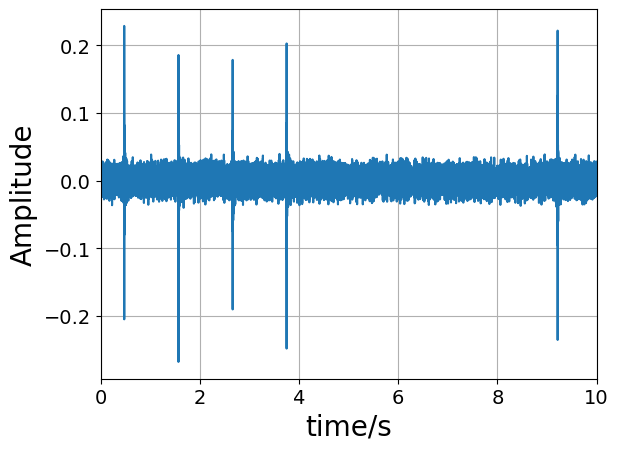

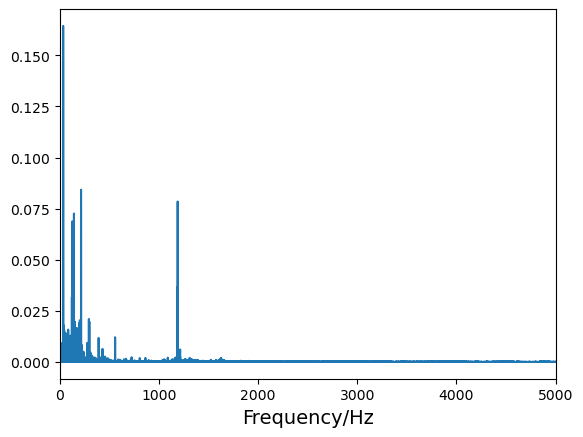

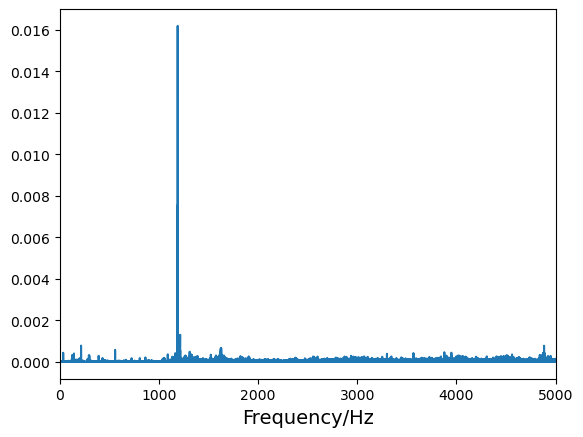

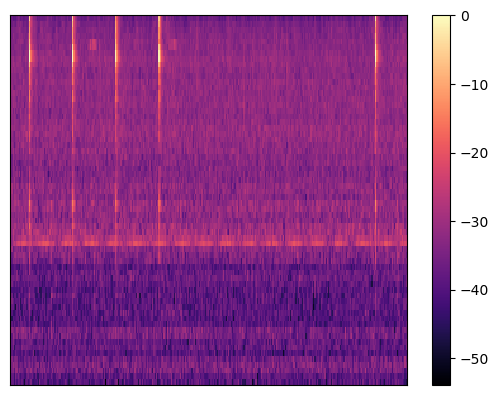

In [9]:
wav_test_file = 'dev_data_valve_00/valve/train/normal_id_00_00000000.wav'
# wav_test_file = 'dev_data_valve_00/valve/test/anomaly_id_00_00000009.wav'

# Visualize your results for potential analysis in your report
features = file_to_features(wav_test_file)

## PyTorch Dataset Splitting

To define and optimize a neural network, we will use the library [PyTorch](http://pytorch.org).

In [181]:
DATA_PATH = "."
MACHINE = "pump_04" # Choice between  "valve_00" or "pump_04"

In [182]:
class MIMII(Dataset):
    def __init__(self, root, machine, train=True, transform=None, target_transform=None):
        if train:
            self.audio_path = os.path.join(root, f"dev_data_{machine}", machine.split("_")[0], "train")
            self.audio_files = os.listdir(self.audio_path)
            self.labels = [int(f.split("_")[0] == "anomaly") for f in self.audio_files]
        else:
            self.audio_path = os.path.join(root, f"dev_data_{machine}", machine.split("_")[0], "test")
            self.audio_files = os.listdir(self.audio_path)
            self.labels = [int(f.split("_")[0] == "anomaly") for f in self.audio_files]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.audio_path, self.audio_files[idx])
        label = self.labels[idx]
        if self.transform:
            f = self.transform(file_path)
        else:
            # default feature representation
            f = file_to_features(file_path).astype(np.float32)
        if self.target_transform:
            label = self.target_transform(label)
        return f, label

In [183]:
# Parameters of the feature extraction
melsp_params = dict(n_mels=64,
                    frames=1,
                    n_fft=1024,
                    hop_length=512,
                    power=2.0,
                    plot=False)


feature_extraction_pipeline = T.Compose([
    T.Lambda(lambda file: file_to_features(file, **melsp_params).astype(np.float32)),
    T.ToTensor()
])

In [184]:
# Pytorch train/test datasets
data_train = MIMII(
    root=DATA_PATH,
    machine=MACHINE,
    train=True,
    transform=feature_extraction_pipeline
)

data_test = MIMII(
    root=DATA_PATH,
    machine=MACHINE,
    train=False,
    transform=feature_extraction_pipeline
)

## AutoEncoder Model Definition

After splitting the dataset and defining our key features, we can move on to model definition and training. Here we will be building a symmetrical autoencoder, defining the decoder symmetrically to the encoder.

In [185]:
class DenseAutoencoder(nn.Module):

    def __init__(self, input_dim):
        super(DenseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            )
        
        # Symetrical neural network to the encoder to reconstuct the input
        # ===================================
        self.decoder = nn.Sequential(
        nn.Linear(32, 128),        
        nn.ReLU(),
        nn.Linear(128, 512),      
        nn.ReLU(),
        nn.Linear(512, input_dim), 
        )
        # ===================================

    def forward(self, x):
        feature = self.encoder(x)
        reconstruction = self.decoder(feature)
        return reconstruction,feature

In [186]:
duration = 10  # s
sr = 16000  # Hz
input_dim = int(duration * sr / melsp_params["hop_length"] + 1) * melsp_params["n_mels"] * melsp_params["frames"]
model = DenseAutoencoder(input_dim)

## Training


Now that the autoencoder is defined we can move onto training. We will be training for 10 epochs (we tried training for more but the loss doesn't seem to improve much more), with a batch sze of 32 (given hyperparam). Over the training loop we will be reconstructing the Mel Spectrogram features extracted in the above dataset construction.

In [187]:
# Training parameters
batch_size = 32
epochs = 10

In [188]:
# PyTorch data loaders allow to iterate batch-wise over a dataset
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True, drop_last=True)

In [189]:
# Stochastic gradient descent optimizer
optimizer = torch.optim.Adam(model.parameters())

# Mean Squared Error (MSE) loss function to be minimized
loss_fn = nn.MSELoss()

In [190]:
def train_loop(dataloader, model, loss_fn, optimizer, print_every=10):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss_running = 0
    for batch, (x, y) in enumerate(tqdm(dataloader)):
        # Compute prediction and loss
        x = x.flatten(start_dim=1)
        optimizer.zero_grad()
        x_pred, features = model(x)
        
        # TODO : write the loss function, compute the gradient, and update the model parameters
        # ===================================
        loss = loss_fn(x_pred, x)
        loss.backward()
        optimizer.step()
        # ===================================
        
        # Back Propagation
        loss_running += loss.item()

    print(f"loss: {loss_running/len(dataloader):>7f}")

def test_loop(dataset, model, loss_fn):
    size = len(dataset)
    test_losses = np.zeros(size)
    store_feature = []
    with torch.no_grad():
        for idx, (x, _) in enumerate(dataset):
            x = x.flatten()
            x_pred,features = model(x)
            store_feature.append(features.detach().cpu().numpy())
            test_losses[idx] = loss_fn(x_pred, x).item()

    return test_losses, np.array(store_feature)

In [191]:
%%time
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer, print_every=1);

Epoch 1
-------------------------------


100%|██████████| 18/18 [00:03<00:00,  5.05it/s]


loss: 99.002483
Epoch 2
-------------------------------


100%|██████████| 18/18 [00:03<00:00,  4.64it/s]


loss: 14.726388
Epoch 3
-------------------------------


100%|██████████| 18/18 [00:03<00:00,  5.38it/s]


loss: 12.682984
Epoch 4
-------------------------------


100%|██████████| 18/18 [00:05<00:00,  3.20it/s]


loss: 12.521468
Epoch 5
-------------------------------


100%|██████████| 18/18 [00:05<00:00,  3.58it/s]


loss: 12.419595
Epoch 6
-------------------------------


100%|██████████| 18/18 [00:03<00:00,  4.84it/s]


loss: 12.347536
Epoch 7
-------------------------------


100%|██████████| 18/18 [00:03<00:00,  5.93it/s]


loss: 12.433596
Epoch 8
-------------------------------


100%|██████████| 18/18 [00:03<00:00,  5.95it/s]


loss: 12.421409
Epoch 9
-------------------------------


100%|██████████| 18/18 [00:03<00:00,  4.61it/s]


loss: 12.804205
Epoch 10
-------------------------------


100%|██████████| 18/18 [00:03<00:00,  4.61it/s]

loss: 12.576416
CPU times: user 1min 38s, sys: 8.35 s, total: 1min 47s
Wall time: 39 s


## Prediction and Evaluation

During our model training, we could see a sharp drop-off in the loss at first, followed by a plateau around 11-12. This suggests that we are indeed learning, and since the rate of learning slows over time, it is a good signal that we are approaching some optimal configuration for our model. Let's now compute the AUC in order to fully answer question 1 and move on to the AUC of other approaches. We will be discussing threshold choices in question 4!

In [192]:
def evaluation_metrics(y_true, y_pred):
    sns.heatmap(metrics.confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f"Confusion Matrix on {MACHINE}");
    plt.show()
    
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()

    # Compute metrics
    accuracy = metrics.accuracy_score(y_true, y_pred)
    tpr_value = metrics.recall_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    f1 = metrics.f1_score(y_true, y_pred)
    fpr_value = fp / (fp + tn)

    # Print the results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"True Positive Rate (Recall): {tpr_value:.4f}")
    print(f"False Positive Rate: {fpr_value:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1-Score: {f1:.4f}")

In [193]:
y_true = data_test.labels
test_losses, extracted_features_test = test_loop(data_test, model, loss_fn)
y_scores = test_losses
train_losses, extracted_features_train = test_loop(data_train, model, loss_fn)

# Compute predictions on test data
y_true = data_test.labels  # Actual labels (0: normal, 1: anomaly)

auc = metrics.roc_auc_score(y_true, y_scores)
print(f"ROC AUC Score on Test Set: {auc:.4f}")

ROC AUC Score on Test Set: 0.7869


# Question 2: One-Class SVM and Isolation Forest

### From the trained AutoEncoder, use the bottleneck features to train a (1) One-Class SVM and (2) Isolation Forest, and report the accuracy, F1-score and auc score of each method.

In [194]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

In [195]:
# Get normal training features
y_pred_train, extracted_features_train = test_loop(data_train, model, loss_fn)

### One-Class SVM

Let's first start by evaluating the one-class SVM model by reporting its AUC. We will also report the accuracy and F1-score given the 

In [196]:
# TODO : Define the OneClassSVM here
# TODO : Fit OneClassSVM here using training data
# TODO : Report essential evaluation metrics
# ===================================
svm = OneClassSVM()
svm.fit(extracted_features_train)
decision_score = -svm.decision_function(extracted_features_test) # for ROC curve and AUC
predicted_score = svm.predict(extracted_features_test) # PREDICTING ON TEST SET
predicted_score = (predicted_score == -1).astype(int)

# ===================================
roc_auc = metrics.roc_auc_score(y_true, decision_score)
print(f"ROC AUC Score on Test Set: {roc_auc:.4f}")

ROC AUC Score on Test Set: 0.5157


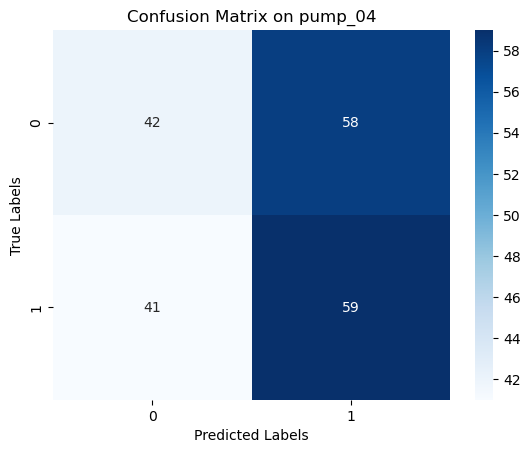

Accuracy: 0.5050
True Positive Rate (Recall): 0.5900
False Positive Rate: 0.5800
Precision: 0.5043
F1-Score: 0.5438


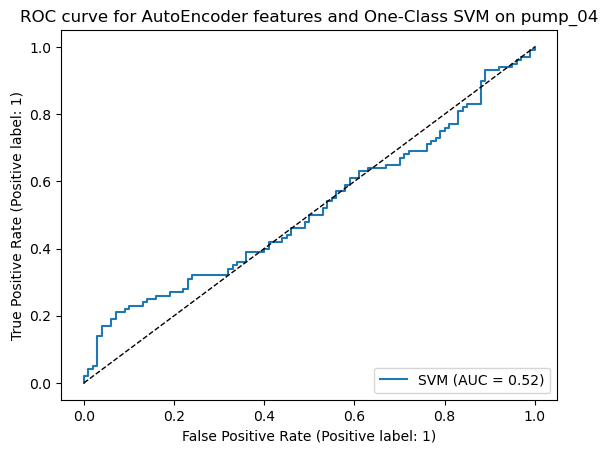

In [197]:
evaluation_metrics(y_true, predicted_score)

metrics.RocCurveDisplay.from_predictions(y_true, decision_score, name="SVM")
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title(f"ROC curve for AutoEncoder features and One-Class SVM on {MACHINE}");

### Isolation Forest

In [198]:
# TODO : Define IsolationForest here
# TODO : Fit IsolationForest here using training data
# TODO : Report essential evaluation metrics
# ===================================
isolation_forest = IsolationForest(contamination = 0.5)
isolation_forest.fit(extracted_features_train)
y_test_proba_iso_forest = -isolation_forest.decision_function(extracted_features_test)
predicted_score = isolation_forest.predict(extracted_features_test) # PREDICTING ON TEST SET
predicted_score = (predicted_score == -1).astype(int)
# ===================================

roc_auc = metrics.roc_auc_score(y_true, y_test_proba_iso_forest)
print(f"ROC AUC Score on Test Set: {roc_auc:.4f}")

accuracy = metrics.accuracy_score(y_true, predicted_score)
print(f"Accuracy Score on Test Set: {accuracy:.4f}")

f1 = metrics.f1_score(y_true, predicted_score)
print(f"F1 Score on Test Set: {f1:.4f}")

ROC AUC Score on Test Set: 0.6285
Accuracy Score on Test Set: 0.5500
F1 Score on Test Set: 0.6121


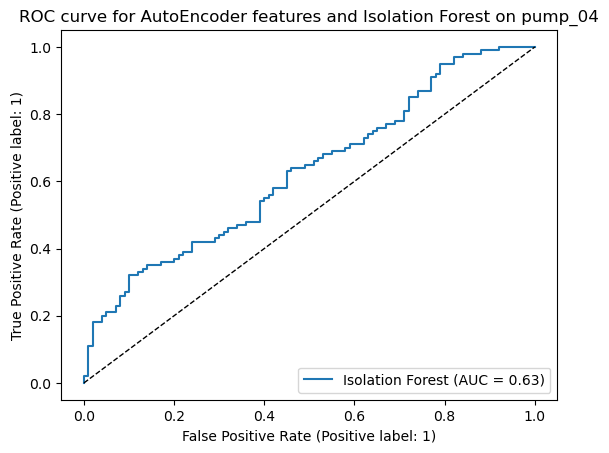

In [199]:
metrics.RocCurveDisplay.from_predictions(y_true, y_test_proba_iso_forest, name="Isolation Forest")
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title(f"ROC curve for AutoEncoder features and Isolation Forest on {MACHINE}");

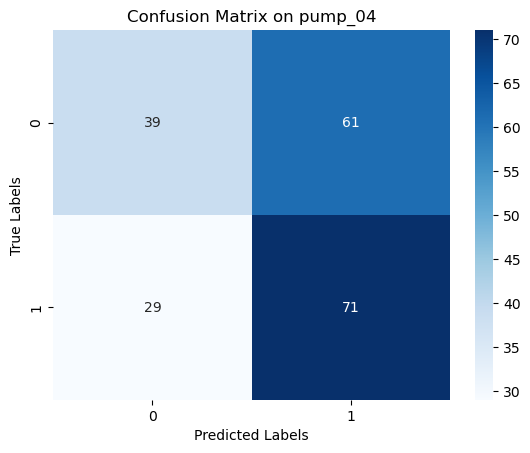

Accuracy: 0.5500
True Positive Rate (Recall): 0.7100
False Positive Rate: 0.6100
Precision: 0.5379
F1-Score: 0.6121


In [200]:
evaluation_metrics(y_true, predicted_score)

# Question 3
### Instead of using AutoEncoder features, apply PCA to project the MEL-spectrogram into a smaller dimensional space, then train (1) a One-Class SVM and (2) an Isolation Forest, and report the AUC scores.

PCA of the spectrograms to reduce the input dimension

In [201]:
# Extract spectrograms of training and testing
flatten_spectogram_train = []
for idx, (x, _) in enumerate(data_train):
    x = x.flatten()
    flatten_spectogram_train.append(x.numpy())
train_spec = np.array(flatten_spectogram_train)

flatten_spectogram_test = []
for idx, (x, _) in enumerate(data_test):
    x = x.flatten()
    flatten_spectogram_test.append(x.numpy())
test_spec = np.array(flatten_spectogram_test)

Apply PCA to fit and transform the training data and transform also the test data

In [202]:
from sklearn.decomposition import PCA

pca = PCA(n_components=64)

# TODO : Fit and transform the training data (train_spec)
# TODO : Transform the testing data (test_spec)
# ===================================
train_spec_pca = pca.fit_transform(train_spec)
test_spec_pca = pca.transform(test_spec)
# ===================================

## One-Class SVM using the new PCA features

In [203]:
y_true = data_test.labels

In [204]:
# TODO : Define the OneClassSVM here
# TODO : Fit OneClassSVM here using PCA features
# TODO : Report essential evaluation metrics
# ===================================
svm_pca = OneClassSVM(gamma = 'scale', nu = 0.54)
svm_pca.fit(train_spec_pca)
predicted_score_proba = -svm_pca.score_samples(test_spec_pca)
predicted_score = svm_pca.predict(test_spec_pca) # PREDICTING ON TEST SET
predicted_score = (predicted_score == -1).astype(int)

roc_auc = metrics.roc_auc_score(y_true, predicted_score_proba)
print(f"ROC AUC Score on Test Set: {roc_auc:.4f}")

accuracy = metrics.accuracy_score(y_true, predicted_score)
print(f"Accuracy Score on Test Set: {accuracy:.4f}")

f1 = metrics.f1_score(y_true, predicted_score)
print(f"F1 Score on Test Set: {f1:.4f}")
# ===================================


ROC AUC Score on Test Set: 0.8501
Accuracy Score on Test Set: 0.7300
F1 Score on Test Set: 0.7823


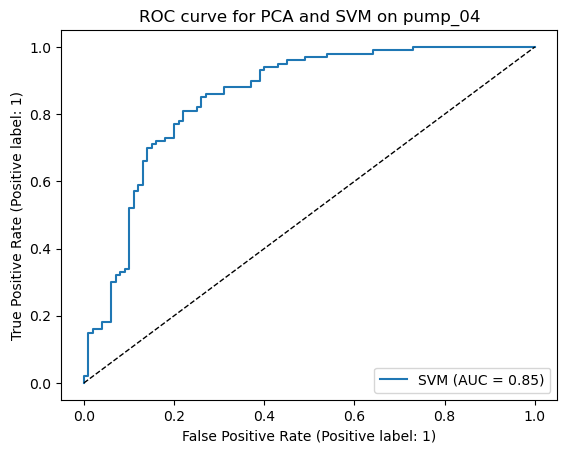

In [205]:
metrics.RocCurveDisplay.from_predictions(y_true, predicted_score_proba, name="SVM")
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title(f"ROC curve for PCA and SVM on {MACHINE}");


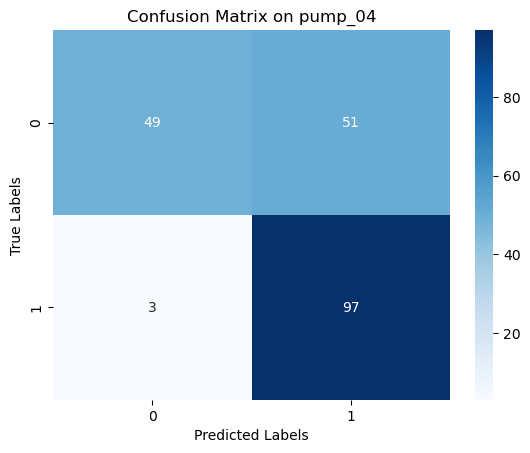

Accuracy: 0.7300
True Positive Rate (Recall): 0.9700
False Positive Rate: 0.5100
Precision: 0.6554
F1-Score: 0.7823


In [206]:
# For the One-Class SVM
evaluation_metrics(y_true, predicted_score)

## Isolation Forest using the new PCA features

In [207]:
# TODO : Define IsolationForest here
# TODO : Fit IsolationForest here using PCA features
# TODO : Report essential evaluation metrics
# ===================================
isolation_forest_pca = IsolationForest(random_state=0, contamination = 0.5).fit(train_spec_pca)
predicted_score_proba = -isolation_forest_pca.score_samples(test_spec_pca)
predicted_score = isolation_forest_pca.predict(test_spec_pca) # PREDICTING ON TEST SET
predicted_score = (predicted_score == -1).astype(int)

print('Isolation Forest Results')
roc_auc = metrics.roc_auc_score(y_true, predicted_score_proba)
print(f"ROC AUC Score on Test Set: {roc_auc:.4f}")

accuracy = metrics.accuracy_score(y_true, predicted_score)
print(f"Accuracy Score on Test Set: {accuracy:.4f}")

f1 = metrics.f1_score(y_true, predicted_score)
print(f"F1 Score on Test Set: {f1:.4f}")
# ===================================

Isolation Forest Results
ROC AUC Score on Test Set: 0.9023
Accuracy Score on Test Set: 0.8200
F1 Score on Test Set: 0.8333


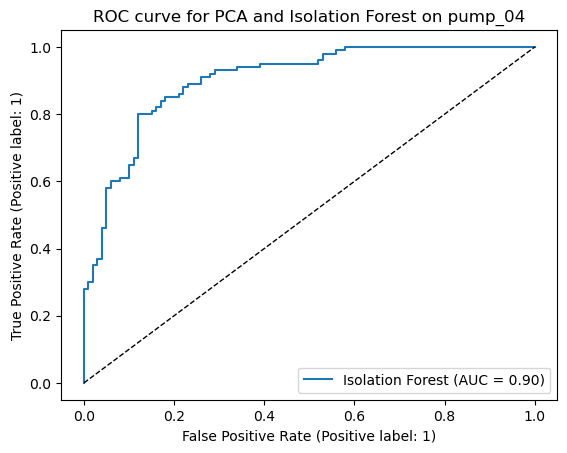

In [208]:
metrics.RocCurveDisplay.from_predictions(y_true, predicted_score_proba, name="Isolation Forest")
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title(f"ROC curve for PCA and Isolation Forest on {MACHINE}");

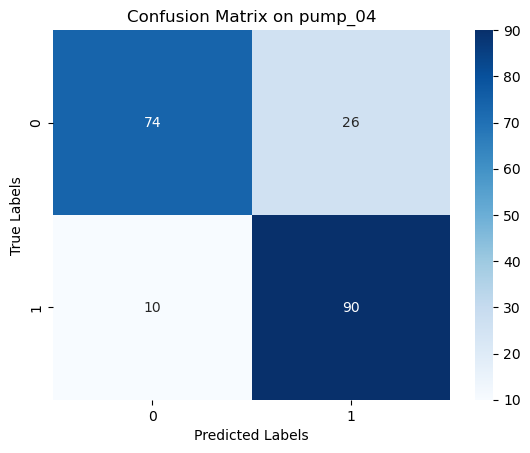

Accuracy: 0.8200
True Positive Rate (Recall): 0.9000
False Positive Rate: 0.2600
Precision: 0.7759
F1-Score: 0.8333


In [209]:
# For the Isolation Forest!
evaluation_metrics(y_true, predicted_score)

# Question 4
### Determine an appropriate threshold for distinguishing anomalies based on the given results, and compute the following metrics: Accuracy, True Positive Rate (TPR), False Positive Rate (FPR), and F1-score.

We will be looking into methods to choose the ideal threshold for 

We will be using two methods to find a "good" threshold: the first will use the training reconstruction loss 

Note: We will be computing the "optimal" threshold using Youden's J statistic in order to find a good first guess. However since in practice, in anomaly detection it is more important to optimize for True Positive Rate, then we could also imagine a further exercise trying to find the "optimal" threshold for us based on some cost optimisation (using the cost of a false positive vs. false negative). For this exercise set we will stick to Youden's J-statistic which weighs both TPR and FPR equally high. 

In [210]:
# TODO : Define a threshold based on test loss for classification
# TODO : Report accuracy, TPR, FPR, F1-Score
# ===================================
def percentile_thresholding(percentile, train_losses, test_losses):
   
    threshold = np.percentile(train_losses, percentile)
    print(f"Threshold (at {percentile}th percentile): {threshold}")

    # Classify test samples based on the threshold
    y_pred = (y_scores >= threshold).astype(int)

    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()

    accuracy = metrics.accuracy_score(y_true, y_pred)
    tpr_value = metrics.recall_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    f1 = metrics.f1_score(y_true, y_pred)
    fpr_value = fp / (fp + tn)
    auc = metrics.roc_auc_score(y_true, y_scores)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"True Positive Rate (Recall): {tpr_value:.4f}")
    print(f"False Positive Rate: {fpr_value:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    print('----------')

    return threshold
# ===================================

In [211]:
def plot_reconstruction_loss(percentile, threshold):
    plt.figure(figsize=(10, 6))
    plt.hist(train_losses, bins=50, alpha=0.5, label='Training Losses (Normal)')
    plt.hist(y_scores[np.array(y_true) == 0], bins=50, alpha=0.5, label='Test Losses (Normal)')
    plt.hist(y_scores[np.array(y_true) == 1], bins=50, alpha=0.5, label='Test Losses (Anomalies)')
    plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold ({percentile}th percentile)')
    plt.title('Reconstruction Losses')
    plt.xlabel('Loss')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [212]:
threshold_50 = percentile_thresholding(50, train_losses, test_losses)
threshold_70 = percentile_thresholding(70, train_losses, test_losses)
threshold_95 = percentile_thresholding(95, train_losses, test_losses)

Threshold (at 50th percentile): 10.664628505706787
Accuracy: 0.6350
True Positive Rate (Recall): 0.8500
False Positive Rate: 0.5800
Precision: 0.5944
F1-Score: 0.6996
AUC: 0.7869
----------
Threshold (at 70th percentile): 14.961162567138672
Accuracy: 0.6850
True Positive Rate (Recall): 0.7100
False Positive Rate: 0.3400
Precision: 0.6762
F1-Score: 0.6927
AUC: 0.7869
----------
Threshold (at 95th percentile): 21.22147636413574
Accuracy: 0.6450
True Positive Rate (Recall): 0.3300
False Positive Rate: 0.0400
Precision: 0.8919
F1-Score: 0.4818
AUC: 0.7869
----------


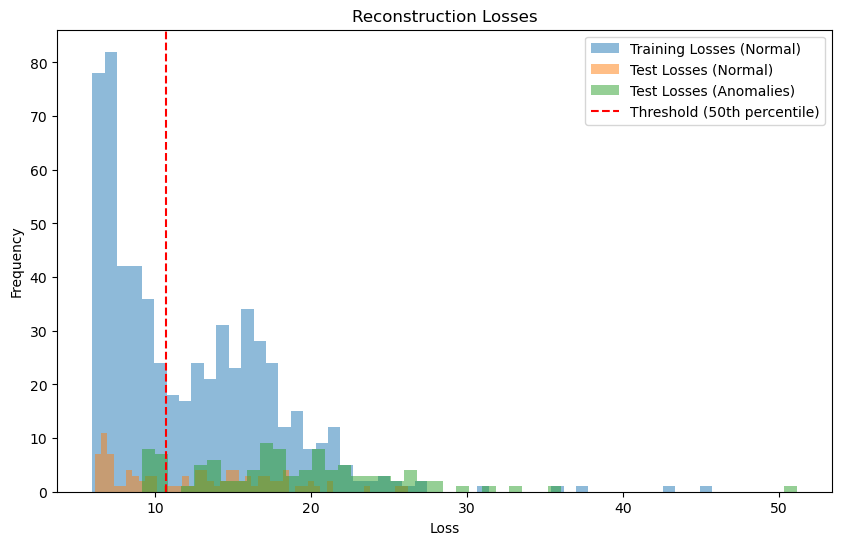

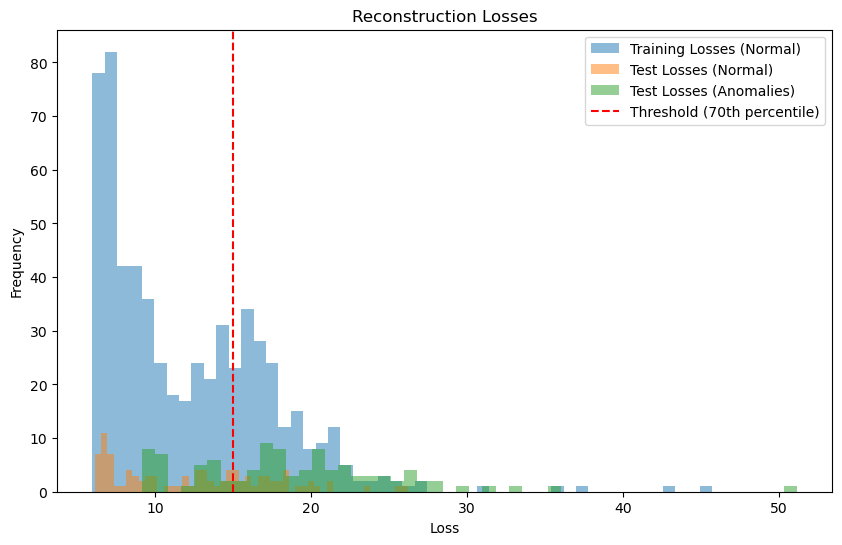

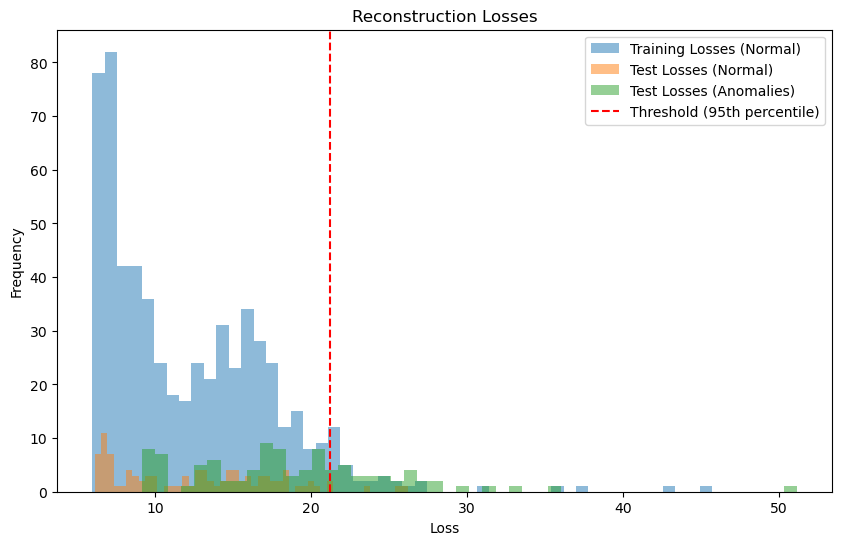

In [213]:
plot_reconstruction_loss(50, threshold_50)
plot_reconstruction_loss(70, threshold_70)
plot_reconstruction_loss(95, threshold_95)

In [214]:
def compute_Youden_J_stat(y_true, y_scores):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_scores)

    # Compute Youden's J statistic
    J_stat = tpr - fpr
    optimal_idx = np.argmax(J_stat)
    optimal_threshold = thresholds[optimal_idx]
    print(f"Optimal Threshold (Youden's J): {optimal_threshold:.4f}")

    return fpr, tpr, thresholds, J_stat, optimal_threshold, optimal_idx

In [215]:
def plot_roc_with_YoudenJ(fpr, tpr, roc_auc, optimal_idx, MACHINE, title='ROC Curve'):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'Autoencoder (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label='Optimal Threshold')
    plt.title(f'{title}: {MACHINE}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.legend()
    plt.show()

In [216]:
def plot_Youden_J(thresholds, J_stat, optimal_idx, title="Youden's J Statistic vs. Thresholds"):
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, J_stat, label="Youden's J Statistic")
    plt.scatter(thresholds[optimal_idx], J_stat[optimal_idx], color='red', label=f'Optimal Threshold = {thresholds[optimal_idx]:.4f}')
    plt.title(title)
    plt.xlabel('Threshold')
    plt.ylabel("Youden's J Statistic")
    plt.legend()
    plt.tight_layout()
    plt.show()

Optimal Threshold (Youden's J): 16.1009


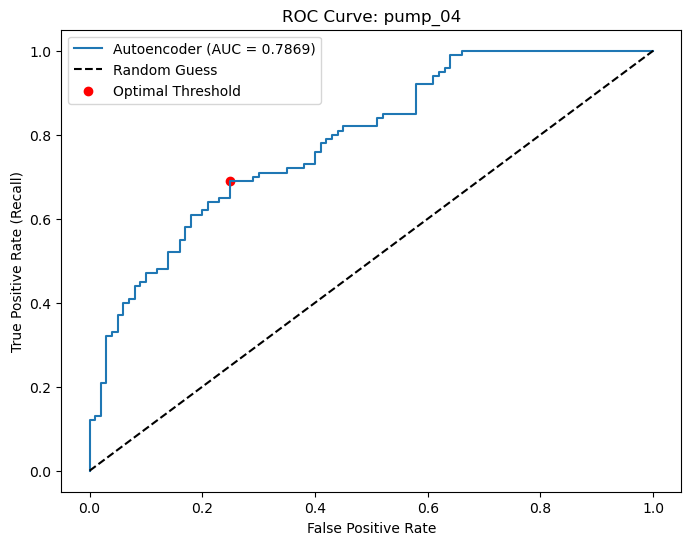

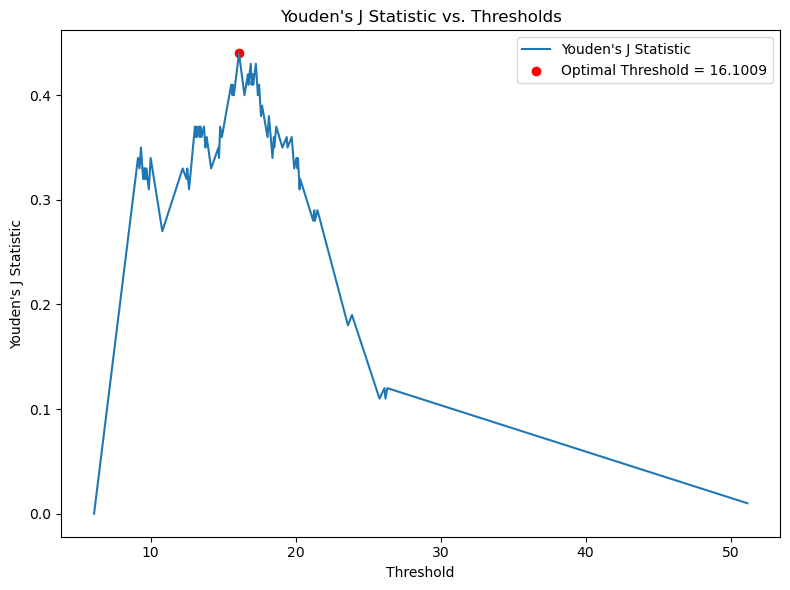

In [217]:
roc_auc = metrics.roc_auc_score(y_true, y_scores)
fpr, tpr, thresholds, J_stat, optimal_threshold, optimal_idx = compute_Youden_J_stat(y_true, y_scores)

plot_roc_with_YoudenJ(fpr, tpr, roc_auc, optimal_idx, MACHINE)
plot_Youden_J(thresholds, J_stat, optimal_idx)

In [218]:
y_pred = (y_scores >= optimal_threshold).astype(int)

tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
accuracy = metrics.accuracy_score(y_true, y_pred)
tpr_value = metrics.recall_score(y_true, y_pred)
precision = metrics.precision_score(y_true, y_pred)
f1 = metrics.f1_score(y_true, y_pred)
fpr_value = fp / (fp + tn)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"True Positive Rate (Recall): {tpr_value:.4f}")
print(f"False Positive Rate: {fpr_value:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.7200
True Positive Rate (Recall): 0.6900
False Positive Rate: 0.2500
Precision: 0.7340
F1-Score: 0.7113


In [219]:
def compute_best_threshold_F1(y_true, y_scores):
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_scores)
    
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    
    # Adjust thresholds array (precision_recall_curve returns thresholds of length n-1)
    thresholds = np.append(thresholds, 1.0)  # Append a dummy threshold for the last point
    
    # Find the threshold that maximizes the F1 score
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    print(f"Optimal Threshold (F1 Score): {optimal_threshold:.4f}")
    
    return precision, recall, thresholds, f1_scores, optimal_threshold, optimal_idx

In [220]:
def plot_precision_recall_with_F1(precision, recall, f1_scores, optimal_idx, MACHINE, title='Precision-Recall Curve'):
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label='Precision-Recall Curve')
    plt.scatter(recall[optimal_idx], precision[optimal_idx], color='red', label='Optimal Threshold')
    plt.title(f'{title}: {MACHINE}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

def plot_roc_with_optimal_F1(fpr, tpr, roc_auc, optimal_threshold, y_true, y_scores, MACHINE, title='ROC Curve'):
    y_pred = (y_scores >= optimal_threshold).astype(int)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    FPR_optimal = fp / (fp + tn)
    TPR_optimal = tp / (tp + fn)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'Autoencoder (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.scatter(FPR_optimal, TPR_optimal, color='red', label='Optimal Threshold')
    plt.title(f'{title}: {MACHINE}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.legend()
    plt.show()

Optimal Threshold (F1 Score): 9.3359


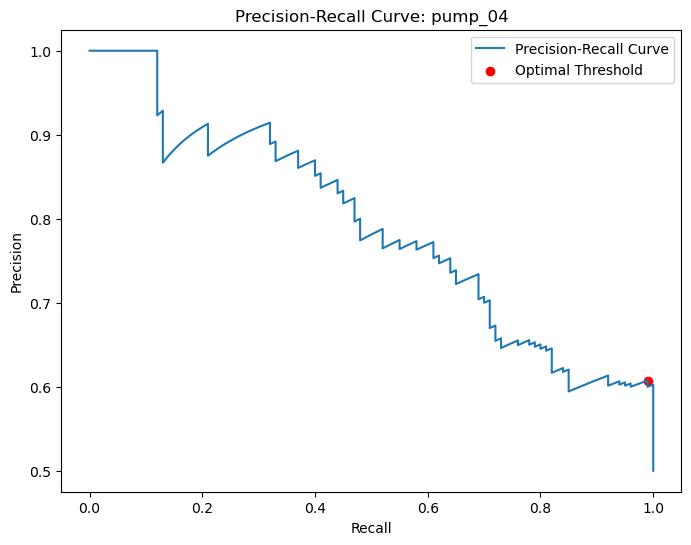

In [221]:
precision, recall, thresholds, f1_scores, optimal_threshold, optimal_idx = compute_best_threshold_F1(y_true, y_scores)
plot_precision_recall_with_F1(precision, recall, f1_scores, optimal_idx, MACHINE)

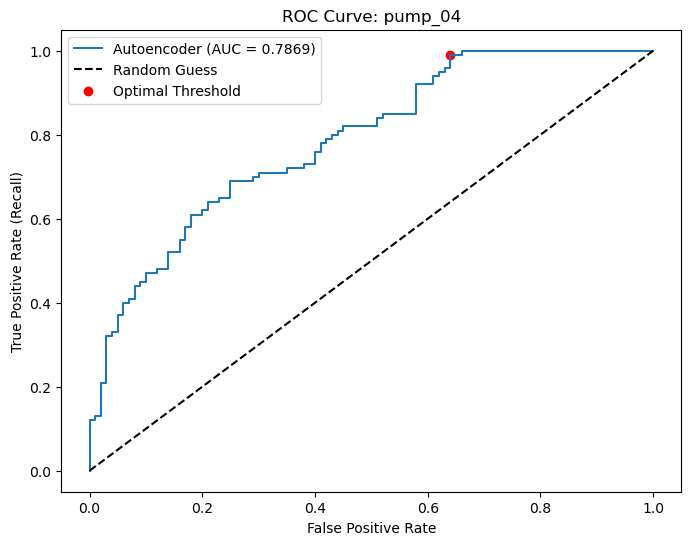

In [222]:
plot_roc_with_optimal_F1(fpr, tpr, roc_auc, optimal_threshold, y_true, y_scores, MACHINE)

In [223]:
y_pred = (y_scores >= optimal_threshold).astype(int)

tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
accuracy = metrics.accuracy_score(y_true, y_pred)
tpr_value = metrics.recall_score(y_true, y_pred)
precision_value = metrics.precision_score(y_true, y_pred)
f1 = metrics.f1_score(y_true, y_pred)
fpr_value = fp / (fp + tn)

print(f"Accuracy: {accuracy:.4f}")
print(f"True Positive Rate (Recall): {tpr_value:.4f}")
print(f"False Positive Rate: {fpr_value:.4f}")
print(f"Precision: {precision_value:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.6750
True Positive Rate (Recall): 0.9900
False Positive Rate: 0.6400
Precision: 0.6074
F1-Score: 0.7529


# **Bonus Question:** Modify the AutoEncoder architecture to a 2D AutoEncoder using convolutional layers instead of fully connected layers, and analyze its performance.

- size of data: 32, 1, 313, 64
- 64 n_mels

In [224]:
import torch
import torch.nn as nn

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # Output: (32, 32, 160, 32)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # Output: (32, 64, 80, 16)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # Output: (32, 128, 40, 8)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), # Output: (32, 256, 20, 4)
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=(0, 0)), # Output: (32, 128, 40, 8)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=(0, 0)),  # Output: (32, 64, 80, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=(0, 0)),   # Output: (32, 32, 160, 32)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=(0, 0)),    # Output: (32, 1, 320, 64)
            nn.Sigmoid()  # Use Sigmoid for reconstruction values
        )

    def forward(self, x):
        encoded = self.encoder(x)
        reconstruction_vals = self.decoder(encoded)
        return reconstruction_vals

# Example usage
model = ConvAutoencoder()
input_tensor = torch.randn(32, 1, 320, 64)  # Batch size of 32, 1 channel, 320 height, 64 width
output_tensor = model(input_tensor)

# Output shapes
print("Input shape:", input_tensor.shape)
print("Output shape:", output_tensor.shape)  # Should match input shape


Input shape: torch.Size([32, 1, 320, 64])
Output shape: torch.Size([32, 1, 305, 49])


In [225]:

# Sample input tensor
input_tensor = torch.randn(32, 1, 313, 64)  # Example shape: (batch_size, channels, height, width)

# Create a padding layer
pad = nn.ZeroPad2d((0, 0, 4, 3))  # (left, right, top, bottom)

# Pad the tensor
padded_tensor = pad(input_tensor)
print("Padded tensor shape:", padded_tensor.shape)

# model = ConvolutionalAutoencoder()
# input_tensor = torch.randn(32, 1, 313, 64)  # Batch size of 32, 1 channel, 313 height, 64 width
# input_tensor = pad(input_tensor)
# output_tensor = model(input_tensor)

# print("Input shape:", input_tensor.shape)
# print("Output shape:", output_tensor.shape)  # Should match input shape

# Example usage
model = ConvAutoencoder()
input_tensor = torch.randn(32, 1, 313, 64)  # Batch size of 32, 1 channel, 313 height, 64 width
input_tensor = pad(input_tensor)
output_tensor = model(input_tensor)

# Output shapes
print("Input shape:", input_tensor.shape)
print("Output shape:", output_tensor.shape)  # Should match input shape


Padded tensor shape: torch.Size([32, 1, 320, 64])
Input shape: torch.Size([32, 1, 320, 64])
Output shape: torch.Size([32, 1, 305, 49])


In [226]:
class ConvolutionalAutoencoder(nn.Module):

    def __init__(self):
        super(ConvolutionalAutoencoder, self).__init__()
      
        self.encoder = nn.Sequential( # [32, 1, 313, 64]
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # (8, 78, 16)
        )
        
        # TODO : write a symetrical neural network to the encoder to reconstuct the input
        # ===================================
        # IMPLEMENT YOUR CODE HERE

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 16, 
                               kernel_size=3, 
                               stride=1, 
                               padding=1, 
                               output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 
                               kernel_size=2, 
                               stride=2, 
                               padding=0, 
                               output_padding=(1,0)), # [32, 1, 313, 64])
        )
        
        # ===================================

    def forward(self, x):
        feature = self.encoder(x)
        reconstruction = self.decoder(feature)
        return reconstruction,feature

In [227]:
model2 = ConvolutionalAutoencoder()

In [228]:
#Create a class autoencoder CNN
class CNNAutoencoder(nn.Module):

    def __init__(self, input_channels=1):
        super(CNNAutoencoder, self).__init__()
        # create CNN encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=input_channels, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, padding= 1),
            nn.Conv1d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, padding=1),
            )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='linear', align_corners=True),  # Adjust the mode and align_corners
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=16, out_channels=8, kernel_size=3),
            nn.Upsample(scale_factor=2, mode='linear', align_corners=True),  # Adjust the mode and align_corners
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=8, out_channels=input_channels, kernel_size=3)
        )
        
    def forward(self, x):
        feature = self.encoder(x)
        reconstruction = self.decoder(feature)
        diffinSize = len(reconstruction[0][0])-len(x[0][0])
        reconstruction = reconstruction[0][0][diffinSize//2:-diffinSize//2] #With the upsample we need to rescale the output the corners are not well defined
        return reconstruction, feature
    
model3 = CNNAutoencoder()

In [229]:
def train_loop2(dataloader, model, loss_fn, optimizer, print_every=10):
    size = len(dataloader.dataset)
    num_batches = dataloader.batch_size
    loss_running = 0
    for batch, (x, y) in enumerate(tqdm(dataloader)):
        # Compute prediction and loss
        x = x.view(num_batches, 1, -1)

        optimizer.zero_grad()

        x_pred,features = model(x)

        #TODO: write the loss function and compute the gradient and update the model parameters
        loss = loss_fn(x_pred, x)

        #to the backpropagation with the loss
        loss.backward()
        optimizer.step()

        # Backpropagation
        loss_running += loss.item()

    print(f"loss: {loss_running/len(dataloader):>7f}")

def test_loop2(dataset, model, loss_fn):
    size = len(dataset)
    test_losses = np.zeros(size)
    store_feature = []
    with torch.no_grad():
        for idx, (x, _) in enumerate(dataset):
            x = x.flatten()
            x = x.view(1,1,-1)
            x_pred,features = model(x)
            store_feature.append(features.detach().cpu().numpy())
            test_losses[idx] = loss_fn(x_pred, x).item()

    return test_losses, np.array(store_feature)

In [230]:
#Get normal training features
def getNewModel(melsp_params, dataToTrain, classEncoder=DenseAutoencoder, batch_size = 32, epochs = 5):
    input_dim = int(duration * sr / melsp_params["hop_length"] + 1) * melsp_params["n_mels"] * melsp_params["frames"]
    print(input_dim)

    if(classEncoder == DenseAutoencoder):
        model = DenseAutoencoder(input_dim)
    else:
        model = CNNAutoencoder()
    # PyTorch data loaders allow to iterate batch-wise over a dataset
    train_loader = DataLoader(dataToTrain, batch_size=batch_size, shuffle=True, drop_last=True)
    
    # Stochastic gradient descent optimizer
    optimizer = torch.optim.Adam(model.parameters())
    # Mean Squared Error (MSE) loss function to be minimized
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        train_loop2(train_loader, model, loss_fn, optimizer, print_every=1)

    return model


In [231]:
CNNAutoEncoderModel = getNewModel(melsp_params, data_train, CNNAutoencoder)

20032
Epoch 1
-------------------------------


  0%|          | 0/18 [00:00<?, ?it/s]/Users/joshuacohendumani/anaconda3/envs/ml4pm/lib/python3.11/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([32, 1, 20032])) that is different to the input size (torch.Size([20032])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 18/18 [00:08<00:00,  2.03it/s]


loss: 103.816610
Epoch 2
-------------------------------


100%|██████████| 18/18 [00:07<00:00,  2.29it/s]


loss: 47.203495
Epoch 3
-------------------------------


100%|██████████| 18/18 [00:07<00:00,  2.31it/s]


loss: 43.401110
Epoch 4
-------------------------------


100%|██████████| 18/18 [00:07<00:00,  2.33it/s]


loss: 43.236010
Epoch 5
-------------------------------


100%|██████████| 18/18 [00:09<00:00,  1.92it/s]

loss: 46.159323


In [232]:
print(len(data_train), len(data_test))
data_train[0][0].shape


602 200


torch.Size([1, 313, 64])

In [233]:
y_pred_train_CNN,extracted_features_train_CNN = test_loop2(data_train, CNNAutoEncoderModel, loss_fn)
y_pred_test_CNN,extracted_features_test_CNN = test_loop2(data_test, CNNAutoEncoderModel, loss_fn)

/Users/joshuacohendumani/anaconda3/envs/ml4pm/lib/python3.11/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 1, 20032])) that is different to the input size (torch.Size([20032])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [234]:
y_true = data_test.labels  # Actual labels (0: normal, 1: anomaly)

auc = metrics.roc_auc_score(y_true, y_pred_test_CNN)
print(f"ROC AUC Score on Test Set: {auc:.4f}")

ROC AUC Score on Test Set: 0.4637


In [235]:
svm = OneClassSVM()

extracted_features_train_CNN = extracted_features_train_CNN.reshape(extracted_features_train_CNN.shape[0], -1)
extracted_features_test_CNN = extracted_features_test_CNN.reshape(extracted_features_test_CNN.shape[0], -1)

svm.fit(extracted_features_train_CNN)
decision_score = -svm.decision_function(extracted_features_test_CNN) # for ROC curve and AUC
predicted_score = svm.predict(extracted_features_test_CNN) # PREDICTING ON TEST SET
predicted_score = (predicted_score == -1).astype(int)

roc_auc = metrics.roc_auc_score(y_true, decision_score)
print(f"ROC AUC Score on Test Set: {roc_auc:.4f}")

accuracy = metrics.accuracy_score(y_true, predicted_score)
print(f"Accuracy Score on Test Set: {accuracy:.4f}")

f1 = metrics.f1_score(y_true, predicted_score)
print(f"F1 Score on Test Set: {f1:.4f}")



ROC AUC Score on Test Set: 0.5497
Accuracy Score on Test Set: 0.4900
F1 Score on Test Set: 0.5321


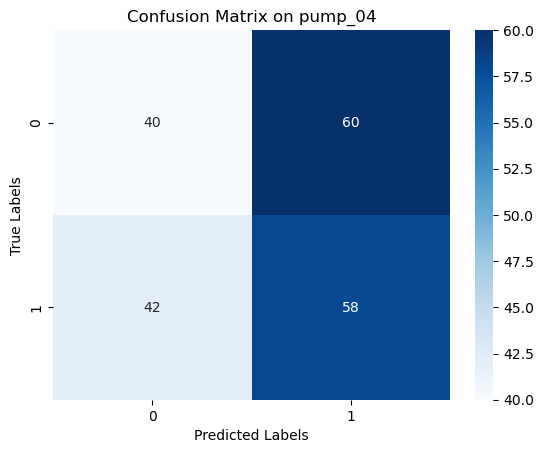

Accuracy: 0.4900
True Positive Rate (Recall): 0.5800
False Positive Rate: 0.6000
Precision: 0.4915
F1-Score: 0.5321


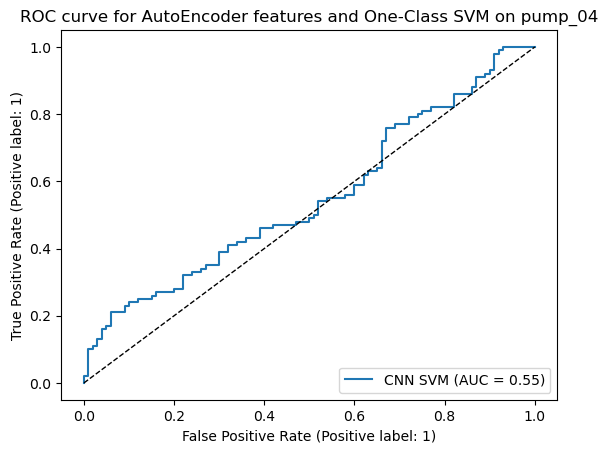

In [236]:
evaluation_metrics(y_true, predicted_score)

metrics.RocCurveDisplay.from_predictions(y_true, decision_score, name="CNN SVM")
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title(f"ROC curve for AutoEncoder features and One-Class SVM on {MACHINE}");